In [ ]:
!pip install d2l==1.0.0-beta0

Mặc dù đã trở nên nổi tiếng trong cộng đồng thị giác máy tính và học máy sau khi LeNet được giới thiệu, mạng nơ-ron tích chập chưa lập tức thống trị lĩnh vực này. Dẫu LeNet đã đạt được kết quả tốt trên những tập dữ liệu nhỏ, chất lượng và tính khả thi của việc huấn luyện mạng tích chập trên một tập dữ liệu lớn và sát thực tế hơn vẫn là một câu hỏi. Trên thực tế, hầu hết trong khoảng thời gian từ đầu những năm 1990 cho tới năm 2012 với những thành tựu mang tính bước ngoặt, mạng nơ-ron tích chập thường không sánh bằng những phương pháp học máy khác, như Máy Vector hỗ trợ - SVM.

Với thị giác máy tính, phép so sánh này dường như không công bằng. Nguyên nhân là do giá trị đầu vào của mạng tích chập chỉ bao gồm giá trị điểm ảnh thô hoặc đã xử lý thô (như định tâm ảnh (centering)), và kinh nghiệm cho thấy những giá trị thô này không bao giờ nên dùng trực tiếp trong các mô hình truyền thống. Thay vào đó, các hệ thống thị giác máy tính cổ điển dùng những pipeline trích xuất đặc trưng một cách thủ công. Thay vì được học, các đặc trưng được tạo thủ công. Hầu hết những tiến triển trong ngành đều đến từ các ý tưởng thông minh hơn trong tạo đặc trưng và ít để ý hơn tới thuật toán học.

Mặc dù cũng đã có các thiết bị phần cứng tăng tốc độ thực thi mạng nơ-ron vào đầu những năm 1990, chúng vẫn chưa đủ mạnh để triển khai những mạng nơ-ron nhiều kênh, nhiều tầng với số lượng tham số lớn. Ngoài ra, những tập dữ liệu vẫn còn tương đối nhỏ. Thêm vào đó, những thủ thuật chính để huấn luyện mạng nơ-ron bao gồm khởi tạo tham số dựa trên thực nghiệm, các biến thể tốt hơn của hạ gradient ngẫu nhiên, hàm kích hoạt không ép (non-squashing activation functions), và thiếu các kỹ thuật điều chuẩn hiệu quả.

Vì vậy, thay vì huấn luyện các hệ thống đầu-cuối (từ điểm ảnh đến phân loại), các pipeline cổ điển sẽ thực hiện các bước sau:

1. Thu thập tập dữ liệu đáng chú ý. Trong những ngày đầu, các tập dữ liệu này đòi hỏi các cảm biến đắt tiền (ảnh có 1 triệu điểm ảnh đã được coi là tối tân nhất vào thời điểm đó).
2. Tiền xử lý tập dữ liệu với các đặc trưng được tạo thủ công dựa trên các kiến thức quang học, hình học, các công cụ phân tích khác và thi thoảng dựa trên các khám phá tình cờ của các nghiên cứu sinh.
3. Đưa dữ liệu qua một bộ trích chọn đặc trưng tiêu chuẩn như SIFT, hoặc SURF, hay bất kỳ pipeline được tinh chỉnh thủ công nào.
4. Dùng các kết quả biểu diễn để huấn luyện một bộ phân loại ưa thích, có thể là một mô hình tuyến tính hoặc phương pháp hạt nhân.

Khi tiếp xúc với những nhà nghiên cứu học máy, bạn sẽ thấy họ tin rằng học máy không những quan trọng mà còn “đẹp” nữa. Bởi lẽ có nhiều lý thuyết tinh vi được đưa ra để chứng minh các tính chất của nhiều bộ phân loại. Và cứ như vậy, lĩnh vực học máy ngày một lớn mạnh, nghiêm ngặt, và hữu dụng hơn bao giờ hết. Tuy nhiên, nếu có dịp thảo luận với một nhà nghiên cứu thị giác máy tính, thì có thể ta lại được nghe một câu chuyện rất khác. Họ sẽ nói rằng sự thật trần trụi trong nhận dạng ảnh là “đặc trưng mới mang tính quyết định tới chất lượng chứ không phải thuật toán học”. Những nhà nghiên cứu thị giác máy tính thời đó có lý do để tin rằng chỉ cần một tập dữ liệu hơi lớn hơn, sạch hơn hoặc một pipeline trích xuất đặc trưng tốt hơn một chút sẽ có ảnh hưởng lớn hơn bất kỳ thuật toán học nào.

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# 8.1.1. Học Biểu diễn Đặc trưng

Nói một cách khác, tại thời điểm đó phần lớn các nhà nghiên cứu tin rằng phần quan trọng nhất của pipeline là sự biểu diễn. Và cho tới năm 2012 việc biểu diễn vẫn được tính toán một cách máy móc. Trong thực tế, thiết kế và xây dựng một tập các hàm đặc trưng mới, cải thiện kết quả, và viết ra phương pháp thực hiện từng là một phần quan trọng của các bài báo nghiên cứu. SIFT, SURF, HOG, Bags of visual words và các bộ trích chọn đặc trưng tương tự đã chiếm ưu thế vượt trội.

Một nhóm các nhà nghiên cứu bao gồm Yann LeCun, Geoff Hinton, Yoshua Bengio, Andrew Ng, Shun-ichi Amari, và Juergen Schmidhuber, lại có những kế hoạch khác. Họ tin rằng đặc trưng cũng có thể được học. Hơn nữa, họ cũng cho rằng để có được độ phức tạp hợp lý, các đặc trưng nên được phân thành thứ lớp với nhiều tầng học cùng nhau, mỗi tầng có các tham số có thể được huấn luyện. Trong trường hợp ảnh, các tầng thấp nhất có thể dùng để phát hiện biên, màu sắc và đường nét. Thật vậy, [Krizhevsky et al., 2012] giới thiệu một biến thể mới của mạng nơ-ron tích chập đã đạt được hiệu năng xuất sắc trong cuộc thi ImageNet.

Một điều thú vị là ở các tầng thấp nhất của mạng, mô hình đã học được cách trích xuất đặc trưng giống như các bộ lọc truyền thống. Hình dưới được tái tạo từ bài báo khoa học trên mô tả các đặc trưng cấp thấp của hình ảnh.

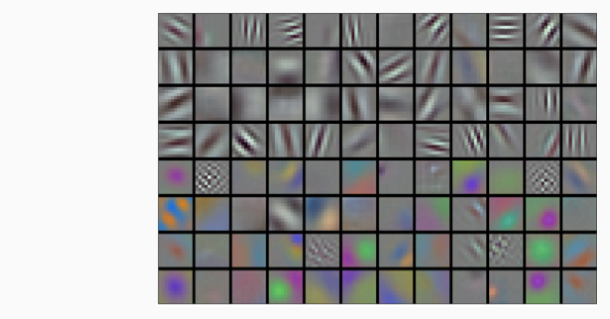

Các tầng cao hơn của mạng sẽ dựa vào các biểu diễn này để thể hiện các cấu trúc lớn hơn như mắt, mũi, ngọn cỏ, v.v. Thậm chí các tầng cao hơn nữa có thể đại diện cho nguyên một vật thể như con người, máy bay, chó hoặc là đĩa ném. Sau cùng, tầng trạng thái ẩn cuối sẽ học cách biểu diễn cô đọng của toàn bộ hình ảnh để tổng hợp lại nội dung sao cho dữ liệu thuộc các lớp khác nhau có thể được dễ dàng phân biệt.

Mặc dù bước đột phá của các mạng tích chập nhiều tầng xuất hiện vào năm 2012, một nhóm nòng cốt các nhà nghiên cứu đã theo đuổi ý tưởng này, tìm cách học các biểu diễn phân tầng của dữ liệu hình ảnh trong nhiều năm. Có hai yếu tố chính dẫn tới bước đột phá lớn vào năm 2012.

## 8.1.1.1. Yếu tố bị Thiếu - dữ liệu

Mô hình học sâu với nhiều tầng đòi hỏi phải có một lượng dữ liệu lớn để đạt hiệu quả vượt trội so với các phương pháp truyền thống dựa trên tối ưu lồi (ví dụ: phương pháp tuyến tính và phương pháp nhân). Tuy nhiên, do khả năng lưu trữ của máy tính còn hạn chế, các bộ cảm biến khá đắt đỏ, và ngân sách dành cho việc nghiên cứu tương đối bị thắt chặt vào những năm 1990, phần lớn các nghiên cứu đều dựa trên những bộ dữ liệu nhỏ. Có rất nhiều bài báo nghiên cứu khoa học giải quyết các vấn đề dựa trên bộ dữ liệu tổng hợp UCI, nhiều bộ dữ liệu trong số đó chỉ chứa khoảng vài trăm hoặc (một vài) ngàn hình ảnh được chụp trong điều kiện không tự nhiên với độ phân giải thấp.

Năm 2009, tập dữ liệu ImageNet được ban hành, thách thức các nhà nghiên cứu huấn luyện những mô hình với 1 triệu hình ảnh, trong đó có 1.000 ảnh cho mỗi 1.000 lớp đối tượng khác nhau. Các nhà nghiên cứu giới thiệu tập dữ liệu này, dẫn đầu bởi Fei-Fei Li, đã tận dụng công cụ Tìm kiếm Hình ảnh của Google để lọc sơ bộ các tập dữ liệu hình ảnh lớn cho mỗi lớp và sử dụng dịch vụ cộng đồng (crowdsourcing) Amazon Mechanical Turk để xác thực nhãn cho từng ảnh. Đây là quy mô lớn chưa từng có từ trước đến nay. Cuộc thi đi liền với tập dữ liệu này được đặt tên là ImageNet Challenge và đã thúc đẩy sự phát triển của nghiên cứu thị giác máy tính và học máy, thách thức các nhà nghiên cứu tìm ra mô hình tốt nhất ở quy mô lớn hơn bao giờ hết trong toàn giới học thuật.

## 8.1.1.2. Yếu tố bị thiếu - Phần cứng

Các mô hình học sâu đòi hỏi rất nhiều chu kỳ tính toán. Quá trình huấn luyện có thể cần hàng trăm epoch, với mỗi vòng lặp yêu cầu đưa dữ liệu qua nhiều tầng nơi các phép toán đại số tuyến tính cồng kềnh được thực thi. Đây là một trong những lý do chính tại sao vào những năm 90 tới đầu những năm 2000, các thuật toán đơn giản dựa trên những mục tiêu tối ưu lồi hiệu quả lại được ưa chuộng hơn.

Bộ xử lý đồ hoạ (GPU) đóng vai trò thay đổi hoàn toàn cuộc chơi khi làm cho việc học sâu trở nên khả thi. Những vi xử lý này đã được phát triển một thời gian dài để tăng tốc độ xử lý đồ họa dành cho các trò chơi máy tính. Cụ thể, chúng được tối ưu hoá cho các phép nhân ma trận - vector 4x4 thông lượng cao, cần thiết cho nhiều tác vụ đồ hoạ. May mắn thay, phép toán này rất giống với phép toán sử dụng trong các tầng tích chập. Trong khoảng thời gian này, hai công ty NVIDIA và ATI đã bắt đầu tối ưu GPU cho mục đích tính toán tổng quát, thậm chí còn tiếp thị chúng dưới dạng GPU đa dụng (General Purpose GPUs - GPGPU).

Để hình dung rõ hơn, hãy cùng xem lại các nhân của bộ vi xử lý CPU hiện đại. Mỗi nhân thì khá mạnh khi chạy ở tần số xung nhịp cao với bộ nhớ đệm lớn (lên đến vài MB ở bộ nhớ đệm L3). Mỗi nhân phù hợp với việc thực hiện hàng loạt các loại chỉ dẫn khác nhau, với các bộ dự báo rẽ nhánh, một pipeline sâu và những tính năng phụ trợ khác cho phép nó có khả năng chạy một lượng lớn các chương trình khác nhau. Tuy nhiên, sức mạnh rõ rệt này cũng có điểm yếu: sản xuất các nhân đa dụng rất đắt đỏ. Chúng đòi hỏi nhiều diện tích cho vi xử lý, cùng cấu trúc hỗ trợ phức tạp (giao diện bộ nhớ, logic bộ nhớ đệm giữa các nhân, kết nối tốc độ cao, v.v.), và chúng tương đối tệ ở bất kỳ tác vụ đơn lẻ nào. Những máy tính xách tay ngày nay chỉ có tới 4 nhân, và thậm chí những máy chủ cao cấp hiếm khi vượt quá 64 nhân, đơn giản bởi vì chúng không hiệu quả về chi phí.

Để so sánh, GPU bao gồm 100-1000 các phần tử xử lý nhỏ (về chi tiết có khác nhau đôi chút giữa NVIDIA, ATI, ARM và các nhà sản xuất khác), thường được gộp thành các nhóm lớn hơn (NVIDIA gọi các nhóm này là luồng (warp)). Mặc dù mỗi nhân thì tương đối yếu, đôi khi thậm chí chạy ở tần số xung nhịp dưới 1GHZ, nhưng số lượng của những nhân này giúp cho GPUs có tốc độ nhanh hơn rất nhiều so với CPUs. Chẳng hạn, thế hệ Volta mới nhất của NVIDIA có thể thực hiện tới 120 nghìn tỷ phép toán dấu phẩy động (TFlop) với mỗi vi xử lý cho những lệnh chuyên biệt (và lên tới 24 TFlop cho các lệnh đa dụng), trong khi hiệu năng của CPU trong việc thực hiện tính toán số thực dấu phẩy động cho đến nay không vượt quá 1 TFlop. Lý do khá đơn giản: thứ nhất, mức độ tiêu thụ năng lượng có xu hướng tăng theo hàm bậc hai so với tần số xung nhịp. Do đó, với cùng lượng năng lượng để một nhân CPU chạy nhanh gấp 4 lần tốc độ hiện tại (mức tăng thường gặp), chúng ta có thể thay bằng 16 nhân GPU với tốc độ mỗi nhân giảm còn 1/4, cũng sẽ cho kết quả là 16 x 1/4 = 4 lần tốc độ hiện tại. Hơn nữa, các nhân của GPU thì đơn giản hơn nhiều (trên thực tế, trong một khoảng thời gian dài những nhân này thậm chí không thể thực thi được các mã lệnh đa dụng), điều này giúp chúng tiết kiệm năng lượng hơn. Cuối cùng, nhiều phép tính trong quá trình học sâu đòi hỏi bộ nhớ băng thông cao. Và một lần nữa, GPUs tỏa sáng khi độ rộng đường bus của nó lớn hơn ít nhất 10 lần so với nhiều loại CPUs.

Quay trở lại năm 2012. Một bước đột phá lớn khi Alex Krizhevsky và Ilya Sutskever đã xây dựng thành công một mạng nơ-ron tích chập sâu có thể chạy trên phần cứng GPU. Họ nhận ra rằng nút thắt cổ chai khi tính toán trong CNN (phép nhân tích chập và ma trận) có thể được xử lý song song trên phần cứng. Sử dụng hai card đồ họa NVIDIA GTX 580s với 3GB bộ nhớ, họ đã xây dựng các phép toán tích chập nhanh. Phần mã nguồn cuda-convnet được xem là ngòi nổ cho sự phát triển vượt bậc của học sâu ngày nay.

# 8.1.2. Mạng AlexNet

Mạng AlexNet được giới thiệu vào năm 2012, được đặt theo tên của Alex Krizhevsky, tác giả thứ nhất của bài báo đột phá trong phân loại ImageNet [Krizhevsky et al., 2012]. Mạng AlexNet bao gồm 8 tầng mạng nơ-ron tích chập, đã chiến thắng cuộc thi ImageNet Large Scale Visual Recognition Challenge năm 2012 với cách biệt không tưởng. AlexNet lần đầu tiên đã chứng minh được rằng các đặc trưng thu được bởi việc học có thể vượt qua các đặc trưng được thiết kế thủ công, phá vỡ định kiến trước đây trong nghiên cứu thị giác máy tính. Cấu trúc mạng AlexNet và LeNet rất giống nhau, như Fig. 7.1.2 đã minh họa. Lưu ý rằng chúng tôi cung cấp một phiên bản AlexNet được sắp xếp hợp lý, loại bỏ một số điểm thiết kế có từ năm 2012 với mục đích làm cho mô hình phù hợp với hai GPU dung lượng nhỏ mà bây giờ đã không còn cần thiết.

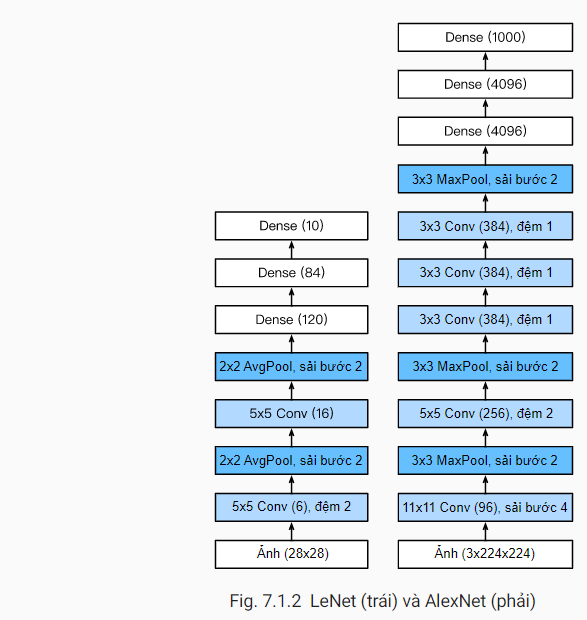

Các triết lý thiết kế của AlexNet và LeNet rất giống nhau, nhưng cũng có những khác biệt đáng kể. Đầu tiên, AlexNet sâu hơn nhiều so với LeNet5. AlexNet có tám tầng gồm: năm tầng tích chập, hai tầng ẩn kết nối đầy đủ, và một tầng đầu ra kết nối đầy đủ. Thứ hai, AlexNet sử dụng ReLU thay vì sigmoid làm hàm kích hoạt. Chúng tôi sẽ đi sâu hơn vào chi tiết ở dưới đây.

## 8.1.2.1. Kiến trúc

Trong tầng thứ nhất của AlexNet, kích thước cửa sổ tích chập là $11×11$. Vì hầu hết các ảnh trong ImageNet đều có chiều cao và chiều rộng lớn gấp hơn mười lần so với các ảnh trong MNIST, các vật thể trong dữ liệu ImageNet thường có xu hướng chiếm nhiều điểm ảnh hơn. Do đó, ta cần sử dụng một cửa sổ tích chập lớn hơn để xác định được các vật thể này. Kích thước cửa sổ tích chập trong tầng thứ hai được giảm xuống còn $5×5$ và sau đó là $3×3$. Ngoài ra, theo sau các tầng chập thứ nhất, thứ hai và thứ năm là các tầng gộp cực đại với kích thước cửa sổ là $3×3$ và sải bước bằng 2. Hơn nữa, số lượng các kênh tích chập trong AlexNet nhiều hơn gấp mười lần so với LeNet.

Sau tầng tích chập cuối cùng là hai tầng kết nối đầy đủ với 4096 đầu ra. Hai tầng này tạo ra tới gần 1 GB các tham số mô hình. Do các GPU thế hệ trước bị giới hạn về bộ nhớ, phiên bản gốc của AlexNet sử dụng thiết kế luồng dữ liệu kép cho hai GPU, trong đó mỗi GPU chỉ phải chịu trách nhiệm lưu trữ và tính toán cho một nửa mô hình. May mắn thay, hiện nay các GPU có bộ nhớ tương đối dồi dào, vì vậy ta hiếm khi cần phải chia nhỏ mô hình trên các GPU (phiên bản mô hình AlexNet của ta khác với bài báo ban đầu ở khía cạnh này).

## 8.1.2.2. Các hàm kích hoạt

Thứ hai, AlexNet đã thay hàm kích hoạt sigmoid bằng hàm kích hoạt ReLU đơn giản hơn. Một mặt là giảm việc tính toán, bởi ReLu không có phép lũy thừa như trong hàm kích hoạt sigmoid. Mặt khác, hàm kích hoạt ReLU giúp cho việc huấn luyện mô hình trở nên dễ dàng hơn khi sử dụng các phương thức khởi tạo tham số khác nhau. Điều này là do khi đầu ra của hàm kích hoạt sigmoid rất gần với 0 hoặc 1 thì gradient sẽ gần như bằng 0, vì vậy khiến cho lan truyền ngược không thể tiếp tục cập nhật một số tham số mô hình. Ngược lại, gradient của hàm kích hoạt ReLU trong khoảng dương luôn bằng 1. Do đó, nếu các tham số mô hình không được khởi tạo đúng cách thì hàm sigmoid có thể có gradient gần bằng 0 trong khoảng dương, dẫn đến việc mô hình không được huấn luyện một cách hiệu quả.

## 8.1.2.3. Kiểm soát năng lực mô hình và Tiền xử lý

AlexNet kiểm soát năng lực của tầng kết nối đầy đủ bằng cách áp dụng dropout (Section 4.6), trong khi LeNet chỉ sử dụng suy giảm trọng số. Để tăng cường dữ liệu thì trong quá trình huấn luyện, AlexNet đã bổ sung rất nhiều kỹ thuật tăng cường hình ảnh chẳng hạn như lật, cắt hay thay đổi màu sắc. Điều này giúp cho mô hình trở nên mạnh mẽ hơn, cùng với đó kích thước dữ liệu lớn hơn giúp làm giảm hiện tượng quá khớp một cách hiệu quả. 

In [3]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

Chúng tôi xây dựng một ví dụ dữ liệu một kênh có cả chiều cao và chiều rộng là 224 để quan sát hình dạng đầu ra của mỗi lớp. Nó phù hợp với kiến ​​trúc AlexNet

In [4]:
AlexNet().layer_summary((1, 1, 224, 224))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

# 8.1.3. Training

Mặc dù AlexNet đã được đào tạo về ImageNet ở Krizhevsky et al. ( 2012 ) , chúng tôi sử dụng Fashion-MNIST ở đây vì đào tạo mô hình ImageNet để hội tụ có thể mất hàng giờ hoặc hàng ngày ngay cả trên GPU hiện đại. Một trong những vấn đề khi áp dụng AlexNet trực tiếp trên Fashion-MNIST là hình ảnh của nó có độ phân giải thấp hơn ( $28 \times 28$ pixel) so với hình ảnh ImageNet. Để làm cho mọi thứ hoạt động, chúng tôi lấy mẫu chúng để $224 \times 224$. Đây thường không phải là một cách làm thông minh, vì nó chỉ làm tăng độ phức tạp tính toán mà không cần thêm thông tin. Tuy nhiên, chúng tôi làm điều đó ở đây để trung thành với kiến ​​trúc AlexNet. Chúng tôi thực hiện thay đổi kích thước này với resize đối số trong d2l.FashionMNIST hàm tạo.

Bây giờ, chúng ta có thể bắt đầu đào tạo AlexNet. So với LeNet trong Phần 7.6 , thay đổi chính ở đây là việc sử dụng tốc độ học nhỏ hơn và đào tạo chậm hơn nhiều do mạng sâu hơn và rộng hơn, độ phân giải hình ảnh cao hơn và chi phí tích chập cao hơn.

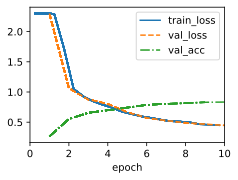

In [5]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)